In [ ]:
# Clone git repo
!git clone https://github.com/AIRI-Institute/HairFastGAN
%cd HairFastGAN

In [ ]:
# Install ninja - small build system to run C++, C
# Install Ninja - small build system https://github.com/ninja-build/ninja
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

In [ ]:
# Install lib
!pip install pyngrok streamlit pillow==10.0.0 face_alignment dill==0.2.7.1 addict fpie git+https://github.com/openai/CLIP.git -q

In [ ]:
!pip install torchvision

In [ ]:
# Download pretrain
!git clone https://huggingface.co/AIRI-Institute/HairFastGAN
!cd HairFastGAN && git lfs pull && cd ..
!mv HairFastGAN/pretrained_models pretrained_models
!mv HairFastGAN/input input
!rm -rf HairFastGAN

In [10]:
# Khai báo các thư viện
from pathlib import Path
from hair_swap import HairFast, get_parser

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as T
import torch


In [11]:
# Khởi tạo model để test
model_args = get_parser()
hair_fast = HairFast(model_args.parse_args([]))

Loading StyleGAN2 from checkpoint: pretrained_models/StyleGAN/ffhq.pt


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


Loading e4e over the pSp framework from checkpoint: pretrained_models/encoder4editing/e4e_ffhq_encode.pt
Network [SPADEGenerator] was created. Total number of parameters: 266.9 million. To see the architecture, do print(network).


100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 135MiB/s]


In [12]:
# Display function
def display_images(images=None, **kwargs):
    is_titles = images is None
    images = images or kwargs

    grid = gridspec.GridSpec(1, len(images))
    fig = plt.figure(figsize=(20, 10))

    for i, item in enumerate(images.items() if is_titles else images):
        title, img = item if is_titles else (None, item)

        img = T.functional.to_pil_image(img) if isinstance(img, torch.Tensor) else img
        img = Image.open(img) if isinstance(img, str | Path) else img

        ax = fig.add_subplot(1, len(images), i+1)
        ax.imshow(img)
        if title:
            ax.set_title(title, fontsize=20)
        ax.axis('off')

    plt.show()

Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1


/content/HairFastGAN/models/sean_codes/models/pix2pix_model.py:140: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  input_label = self.FloatTensor(bs, nc, h, w).zero_()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


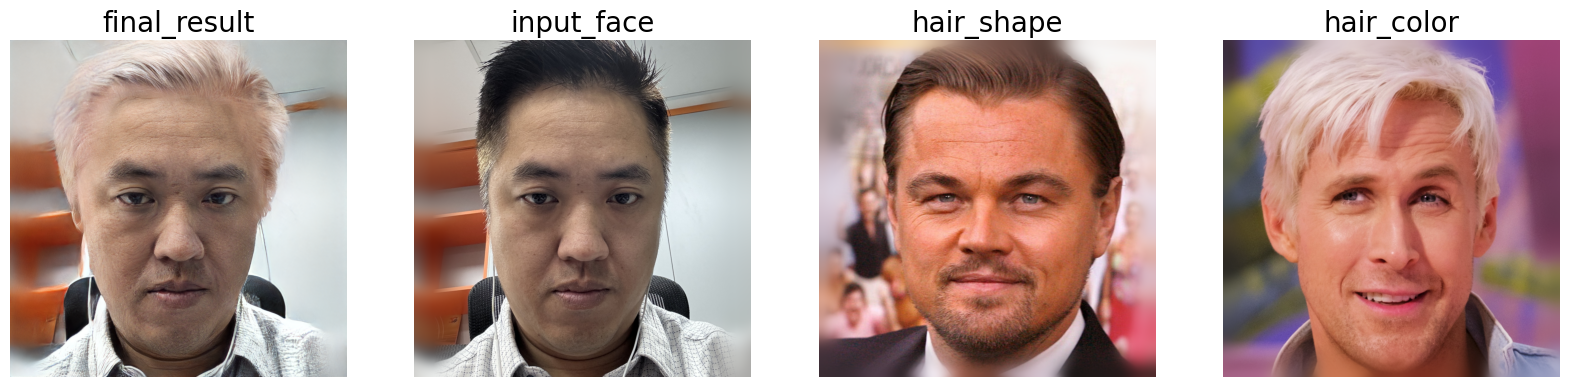

In [13]:
input_dir = Path("/content/HairFastGAN/input")
face_path = input_dir / 'face1.jpg'
shape_path = input_dir / '1.png'
color_path = input_dir / '2.png'

final_image, face_align, shape_align, color_align = hair_fast.swap(face_path,shape_path,color_path, align=True)

%matplotlib inline
display_images(final_result=final_image, input_face=face_align, hair_shape=shape_align, hair_color=color_align)


In [14]:
%%writefile app.py
import streamlit as st
import pandas as pd
from io import StringIO
from pathlib import Path

# Init model
from pathlib import Path
from hair_swap import HairFast,get_parser
# import requests
from io import BytesIO
from PIL import Image
# from functools import cache

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as T
import torch


if "model" not in st.session_state.keys():
    model_args = get_parser()
    hair_fast = HairFast(model_args.parse_args([]))
    st.session_state["model"] = hair_fast

hair_fast = st.session_state["model"]

st.set_page_config(
        page_title="Virtual Hair",
)

st.title("Salon ABC - Virtual Hair Style")
input_face = st.file_uploader("Chọn ảnh khuôn mặt bạn")
hair_shape = st.file_uploader("Chọn ảnh mẫu tóc")
hair_color = st.file_uploader("Chọn ảnh màu tóc")


if st.button("Change me!!!", type="primary"):
    # st.image('result.png', caption='Sunrise by the mountains')

    if input_face is not None and hair_shape is not None and hair_color is not None:
        # To read file as bytes:
        save_folder = '/content/HairFastGAN/upload'
        face_path = Path(save_folder, input_face.name)
        with open(face_path, mode='wb') as w:
            w.write(input_face.getvalue())
        shape_path = Path(save_folder, hair_shape.name)
        with open(shape_path, mode='wb') as w:
            w.write(hair_shape.getvalue())
        color_path = Path(save_folder, hair_color.name)
        with open(color_path, mode='wb') as w:
            w.write(hair_color.getvalue())

        final_image, face_align, shape_align, color_align =  hair_fast.swap(face_path, shape_path, color_path, align=True)
        # Save output to file ressult.png
        save_path = Path(save_folder, 'result.png')
        final_image = T.functional.to_pil_image(final_image)
        # final_image.save(save_path)
        st.image(final_image, caption='Render result')
        del final_image, face_align, shape_align, color_align




Writing app.py


In [15]:
# Run app.py by streamlit
!streamlit run app.py&>/dev/null&
!pgrep streamlit

10525


In [16]:
# Expose by grok
!ngrok authtoken <>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!ngrok http 8501